# Chapter 13: Naive Bayes

### Some Theory

Here we will build a Naive Bayes Classifier for the Spam/Ham classification problem. Nai                                                                                                 ve Baye is built on Bayes theorem, as given below:

$P(A|B) = \displaystyle \frac{P(B|A)P(A)}{P(B|A)P(A)+P(B|\neg A)P(\neg A)} $

In the email classification domain we would treat the event $A$ as the "this email is s                                                                                                 pam" and then the event $B$ as some feature of the given email.

A common $B$ feature to use would be the existance of a certain word. Thus if we set som                                                                                                 e event $V$ as "the message contains the word viagra", then $P(A|V)$ would be the probabili                                                                                                 ty that an email is spam given that it contains the word "Viagra". 

Key passage:
> The key to Naive Bayes is making the (big) assumption that the precences (or absences)                                                                                                  of each word are independent of one another, conditional on the message being spam or not.
                                                                                                 
Given this independence assumption we can make take the following mathematical step:

$\displaystyle P(X_1 = x_1, \ldots, X_n = x_n | S) = P(X_1=x_1|S) \times \cdots \times P(X_n=x_n|S) = \prod_{i=1}^n P(X_i=x_i|S)$

Thus applying Bayes Theorem we can calculate the probability of a message being spam or                                                                                                  not by simply coming up with an estimate for $P(X_i|S)$ and $P(X_i|\neg S)$ for each feature $X_i$. If we use word existance for our feature, estimating these values is then as simple as counting words from labeled spam/ham messages, given the following "smoothing" measure to account for missing data (called _pseudocounting_):

$P(X_i|S) = \displaystyle \frac{k + \text{ number of spams containing } w_i}{2k + \text{number of spams}}$

### An Implementation

In [1]:
from collections import defaultdict, Counter
import math
class NaiveBayesClassifier:
    def __init__(self, k=0.5):
        self.k = k
        self.word_probs = []

    def train(self, training_set):
    
        # count spam and non-spam messages
        num_spams = len([is_spam 
                         for message, is_spam in training_set 
                         if is_spam])
        num_non_spams = len(training_set) - num_spams

        # run training data through our "pipeline"
        word_counts = NaiveBayesClassifier.count_words(training_set)
        self.word_probs = NaiveBayesClassifier \
                            .word_probabilities(word_counts, 
                                                 num_spams, 
                                                 num_non_spams,
                                                 self.k)
        
    def classify(self, message):
        return NaiveBayesClassifier.spam_probability(self.word_probs, message)
        
    
    # Static methods
    def tokenize(message):
        message = message.lower()                       # convert to lowercase
        all_words = re.findall("[a-z0-9']+", message)   # extract the words
        return set(all_words)                           # remove duplicates


    def count_words(training_set):
        """training set consists of pairs (message, is_spam)"""
        counts = defaultdict(lambda: [0, 0])
        for message, is_spam in training_set:
            for word in NaiveBayesClassifier.tokenize(message):
                counts[word][0 if is_spam else 1] += 1
        return counts

    def word_probabilities(counts, total_spams, total_non_spams, k=0.5):
        """turn the word_counts into a list of triplets 
        w, p(w | spam) and p(w | ~spam)"""
        return [(w,
                 (spam + k) / (total_spams + 2 * k),
                 (non_spam + k) / (total_non_spams + 2 * k))
                 for w, (spam, non_spam) in counts.items()]

    def spam_probability(word_probs, message):
        message_words = NaiveBayesClassifier.tokenize(message)
        log_prob_if_spam = log_prob_if_not_spam = 0.0
        
        # iterate through each word in our vocab
        for word, prob_if_spam, prob_if_not_spam in word_probs:

            # for each word in the message, 
            # add the log probability of seeing it 
            if word in message_words:
                log_prob_if_spam += math.log(prob_if_spam)
                log_prob_if_not_spam += math.log(prob_if_not_spam)

            # for each word that's not in the message
            # add the log probability of _not_ seeing it
            else:
                log_prob_if_spam += math.log(1.0 - prob_if_spam)
                log_prob_if_not_spam += math.log(1.0 - prob_if_not_spam)
                
        prob_if_spam = math.exp(log_prob_if_spam)
        prob_if_not_spam = math.exp(log_prob_if_not_spam)
        return prob_if_spam / (prob_if_spam + prob_if_not_spam)

### Using some data

Using the SpamAssassin public corpus (use `./DownloadCh13SpamData.sh` to download the da                                                                                                 ta)

In [2]:
if __name__ == "__main__":
    import glob, re, sys, random
    import NotebookLoader
    sys.meta_path.append(NotebookLoader.NotebookFinder())
    import Chapter11 as CH11
    
    path = r"./Ch13_data/*/*"
    
    data = []
    
    # use glob.glob to return every filename that matches our path wildcard
    for fn in glob.glob(path):
        is_spam = "ham" not in fn
        
        with open(fn,'r',encoding = "ISO-8859-1") as file:
            for line in file:
                if line.startswith("Subject:"):
                    # remove the leading "Subject:" and keep what is left
                    subject = re.sub(r"^Subject: ", "", line).strip()
                    data.append((subject, is_spam))

importing Jupyter notebook from Chapter11.ipynb


### Spam vs Ham

In [3]:
if __name__ == "__main__":
    numSpam = sum([1 for _,isSpam in data if isSpam])
    numHam = len(data) - numSpam
    print("There are {0} Spam\nThere are {1} Ham".format(numSpam, numHam))
    print("This gives a spam-ham ratio of {0}".format(numSpam/numHam))

There are 503 Spam
There are 2920 Ham
This gives a spam-ham ratio of 0.17226027397260274


### Train classifier

In [4]:
if __name__ == "__main__":
    # set seed for consistency
    random.seed(0) 
    
    train_data, test_data = CH11.split_data(data, 0.75)
    
    classifier = NaiveBayesClassifier()
    classifier.train(train_data)

### Classifier Testing Data

In [5]:
if __name__ == "__main__":
    # make triplets: (subject, actual is_spam, predicted is_spam prob)
    classified = [(subject, is_spam, classifier.classify(subject))
                  for subject, is_spam in test_data]
    
    # assume 0.5 probability cutoff, count combinations of (is_spam, pred_is_spam)
    counts = Counter((is_spam, spam_prob > 0.5) 
                     for _, is_spam, spam_prob in classified)
    
    print(counts)

Counter({(False, False): 717, (True, True): 86, (True, False): 48, (False, True): 25})


### Pull out Accuracy, Precision, Recall, and $F_1$ Score

In [6]:
if __name__ == "__main__":
    TN = counts[(False, False)]
    TP = counts[(True, True)]
    FN = counts[(True, False)]
    FP = counts[(False, True)]
    
    print("True Negatives: {0}".format(TN))
    print("True Positives: {0}".format(TP))
    print("False Negatives: {0}".format(FN))
    print("False Positves: {0}".format(FP))
    
    print("Accuracy: {0:.3f}".format(CH11.accuracy(TP, FP, FN, TN)))
    print("Precision: {0:.3f}".format(CH11.precision(TP, FP, FN, TN)))
    print("Recall: {0:.3f}".format(CH11.recall(TP, FP, FN, TN)))
    print("F1 Score: {0:.3f}".format(CH11.f1_score(TP, FP, FN, TN)))

True Negatives: 717
True Positives: 86
False Negatives: 48
False Positves: 25
Accuracy: 0.917
Precision: 0.775
Recall: 0.642
F1 Score: 0.702


### Spammy Hams and Hammy Spams

In [7]:
if __name__ == "__main__":
    # sort by spam prob (ascending)
    classified.sort(key = lambda row: row[2])
    
    # highest predicted spam probabilities among the non-spams
    spammiest_hams = list(filter(lambda row: not row[1], classified))[-5:]
    
    # the lowest predict spam probabilities among the actual spams
    hammiest_spams = list(filter(lambda row: row[1], classified))[:5]
    
    print("Spammiest Hams: {0}\n\n".format(spammiest_hams))
    print("Hammiest Spams: {0}\n\n".format(hammiest_spams))

Spammiest Hams: [('FREE SHIPPING! No Minimum Purchase* at Buy.com', False, 0.9973043373420754), ('[ILUG-Social] Re: Important - reenactor insurance needed', False, 0.9983860089741905), ('=?iso-8859-1?Q?Matrox_Parhelia=99_now_available?=', False, 0.9996572307935723), ('=?iso-2022-jp?B?UmU6IBskQjswSSkyPTNYJSglcyU4JUslIiVqJXMlME1NJVcbKEI=?=', False, 0.9999875315335071), ('=?iso-2022-jp?B?GyRCRnxLXDhsJE43b0w+IUolNSVWJTglJyUvJUghSyEhJTkbKEI=?=', False, 0.9999875315335071)]


Hammiest Spams: [('Re: Hi', True, 0.0004378519507498506), ('Testing a system, please delete', True, 0.001485592401614403), ('Tired of paying big bucks for cable', True, 0.0016459111795913517), ('*****SPAM*****', True, 0.001834171526441301), ('.Message report from your contact page....//ytu855 rkq', True, 0.0028724699034065105)]




### Spammiest words

In [8]:
def p_spam_given_word(word_prob):
    """uses bayes's theorem to compute p(spam | message contains word)"""
    # word_prob is one of the triplets produced by word_probabilities
    word, prob_if_spam, prob_if_not_spam = word_prob
    return prob_if_spam / (prob_if_spam + prob_if_not_spam)

if __name__ == "__main__":
    words = sorted(classifier.word_probs, key=p_spam_given_word)
    print("Spammiest Words: {0}\n\n".format(words[-5:]))
    print("Hammiest Words: {0}\n\n".format(words[:5]))

Spammiest Words: [('systemworks', 0.031081081081081083, 0.0002294630564479119), ('zzzz', 0.031081081081081083, 0.0002294630564479119), ('adv', 0.041891891891891894, 0.0002294630564479119), ('money', 0.041891891891891894, 0.0002294630564479119), ('rates', 0.0445945945945946, 0.0002294630564479119)]


Hammiest Words: [('satalk', 0.0013513513513513514, 0.047957778797613586), ('spambayes', 0.0013513513513513514, 0.04703992657182194), ('users', 0.0013513513513513514, 0.040614960991280404), ('razor', 0.0013513513513513514, 0.03510784763653052), ('zzzzteana', 0.0013513513513513514, 0.02914180816888481)]




### TP/FP Rate Calculator

In [9]:
# make ROC values given p threshold (returns (false positive rate, true posiitve rate pair))
def calc_fp_tp_rates(p, classified):
    # assume 0.5 probability cutoff, count combinations of (is_spam, pred_is_spam)
    counts = Counter((is_spam, spam_prob > p) 
                     for _, is_spam, spam_prob in classified)
    
    # get counts 
    TN = counts[(False, False)]
    TP = counts[(True, True)]
    FN = counts[(True, False)]
    FP = counts[(False, True)]
    
    # false positive rate is FP/(FP + TN)
    fpr = FP/(FP + TN)
    
    # true positive rate is TP/(TP + FN)
    tpr = TP/(TP + FN)
    
    return (fpr, tpr)

def lin_space(x, y, n):
    delta = (y - x) / n
    return [x + delta * i for i in range(n + 1)]

### Plot ROC Curve

We will do this by varying the probability threshold over the interval $[0,1]$ and caclulating the $TP$ (true positive) and $FP$ (false positive) rates for each value in the interval.

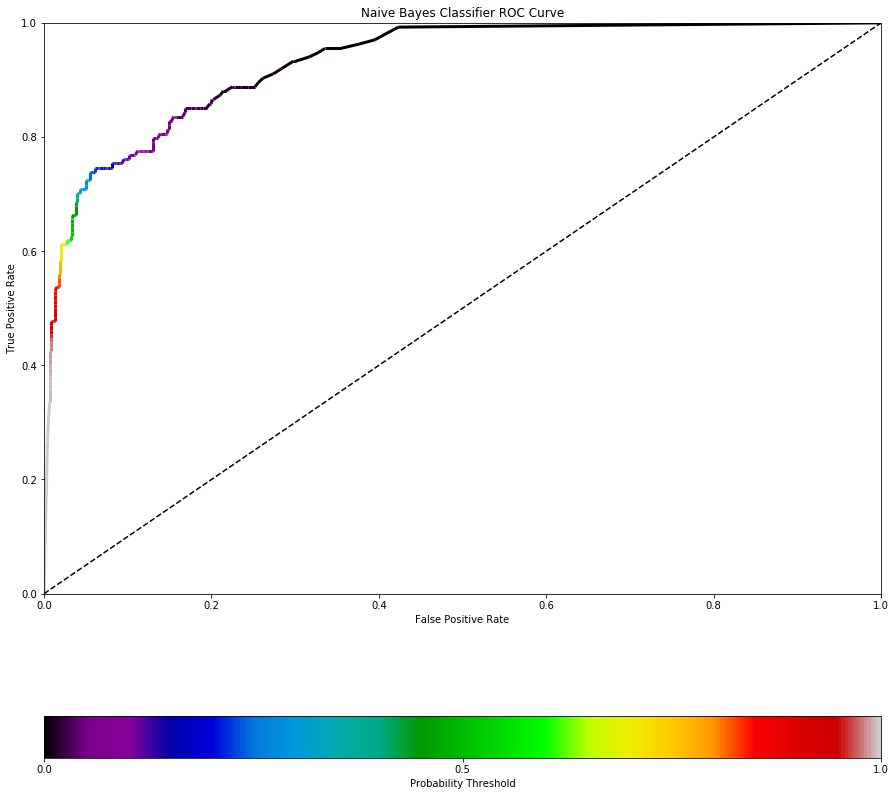

In [10]:
if __name__ == "__main__":
    # Imports 
    import numpy as np
    %matplotlib inline
    import matplotlib.pyplot as plt
    from matplotlib.collections import LineCollection
    from matplotlib.colors import ListedColormap, BoundaryNorm
    from pylab import rcParams
    
    # Set plot size
    rcParams['figure.figsize'] = 15,15

    # calculate ROC vals for each probability value over [0,1]
    interval = lin_space(0, 1, 1000)
    roc_vals = [calc_fp_tp_rates(p, classified) for p in interval]
    
    # unzip into x (FP) and y(TP) arrays
    x, y = zip(*roc_vals)
    
    # Make LineCollection (allows continuous line coloring according to colormap)
    points = np.array([np.array(x), np.array(y)]).T.reshape(-1, 1, 2)
    segments = np.concatenate([points[:-1], points[1:]], axis=1)
    lc = LineCollection(segments, cmap=plt.get_cmap('nipy_spectral'), norm=plt.Normalize(0, 1))
    interval = np.array(interval)
    lc.set_array(interval)
    lc.set_linewidth(3)
    
    # Make figure and set params
    fig2 = plt.figure()
    plt.gca().add_collection(lc)
    plt.xlim(0, 1)
    plt.ylim(0, 1)
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("Naive Bayes Classifier ROC Curve")
    cbar = fig2.colorbar(lc, ticks=[0, 0.5, 1], orientation='horizontal', label="Probability Threshold")
    
    # Add reference identity line (represents random guess threshold)
    plt.plot([0,1], 'k--')
    
    # Show the figure
    plt.show()

### Area Under ROC Curve

We can now estimate the Area Under the ROC curve (another measure of model performance) using the Trapezoidal Rule for numerical integration

Recall that the area of a trapezoid is given by $\displaystyle = \frac{a+b}{2}\cdot h$. Thus given a series of $(x_i, y_i)$ pairs (where the $x_i$'s are monotonically increasing) the area under the curve is given by:

$\text{Area Under Curve } \approx \displaystyle \sum^{n-1}_{i=1} \frac{y_i + y_{i+1}}{2} \cdot (x_{i+1} - x_i)$

In [11]:
def trapezoidal_rule_AUC(x_y_pts):
    """
        Returns an approx of the area under the curve defined by the x_y_points
        ** Assumes that the x values are monotonically increasing
    """
    return sum([((y_i + y_i1)/2) * (x_i1 - x_i) for (x_i, y_i), (x_i1, y_i1) in zip(x_y_pts[:-1], x_y_pts[1:])])

if __name__ == "__main__":
    # need to reverse roc_vals, x is descending
    roc_vals.reverse()
    auc = trapezoidal_rule_AUC(roc_vals)
    print("The Area Under the ROC Curve is {0:.3f}".format(auc))

The Area Under the ROC Curve is 0.929


Thus our ROC AUC is close to 1 (maximum) so our model performs pretty well.